In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

In [82]:
import math

vid = cv2.VideoCapture(0)

def mostrarTexto(frame,texto,punto,fuente=cv2.FONT_HERSHEY_SIMPLEX,escalaFuente=0.5,color=(255,255,255),grosor=1):
    cv2.putText(frame, texto,punto,fuente,escalaFuente,color,grosor)


def mouse_events(event, x, y, flags, params):
    global circulos, circuloReferencia, monedasImg, valorTotal
    # Movimiento del puntero     
    if event==cv2.EVENT_LBUTTONDOWN:
        if circuloReferencia is None:
            for circulo in circulos:
                (cx,cy) = circulo['centro']
                distanciaCentro = math.sqrt(pow(x - cx,2)+pow(y - cy,2))
                if (distanciaCentro > circulo['radio']):
                    continue
                circuloReferencia = circulo
                break
        elif valorTotal is None:
            if x > monedasImg.shape[1] or y > monedasImg.shape[0]:
                return
            valor = monedasImgSegments[int(x / (monedasImg.shape[1]/2))][int(y / (monedasImg.shape[0]/4))]
            mmpp = monedasRef[valor] / (circuloReferencia['radio']*2)
            calcularTotal(mmpp)

def calcularTotal(mmpp):
    global valorTotal
    valorTotal = 0
    for circulo in circulos:
        diametro = circulo['radio']*2*mmpp
        minDif = 1000
        masCercano = None
        for k in monedasTipo[circulo['tipo']]:
            value = monedasRef[k]
            dif = abs(value-diametro)
            if dif < minDif:
                minDif = dif
                masCercano = k
        if minDif < 1:
            valorTotal += float(masCercano)
    return valorTotal

def procesarImagen(img):
    global circulos
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Umbralizado con método de Otsu para selección automática del umbral
    th2,img_th = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    if (img_th[0][0] == 255):
        img_th[:,:] = 255 - img_th[:,:]
    contornos, hierarchy = cv2.findContours(img_th, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)
    candidatos = []
    for c in contornos:
        area = cv2.contourArea(c)
        if area > 10:
            clon = len(c)
            if clon >= 5:
                elipse = cv2.fitEllipse(c)
                (center, axes, orientation) = elipse
                major_axis = max(axes)
                minor_axis = min(axes)
                elipse_ratio = major_axis / minor_axis
                if elipse_ratio > 1.2:
                    continue
            else:
                continue
            (cx,cy),radio = cv2.minEnclosingCircle(c)
            candidatos.append({
                "centro": (int(cx),int(cy)),
                "radio": int(radio),
                "tipo": 0
            })
    circulos = []
    copia = img.copy()
    mascara = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
    for circulo in candidatos:
        circulos.append(circulo)
        cv2.circle(img,circulo['centro'],circulo['radio'],(0,255,0),1)
        cv2.circle(mascara,circulo['centro'],circulo['radio'],(255),-1)
    copia = cv2.bitwise_and(copia,copia,mask=mascara)
    copia = cv2.cvtColor(copia,cv2.COLOR_BGR2HSV)
    mascara = cv2.inRange(copia,(0,50,0),(15,255,255))
    for circulo in circulos:
        x0, y0 = circulo['centro']
        x1 = int(x0+radio/2)
        y1 = int(y0+radio/2)
        segment = mascara[y0:y1,x0:x1]
        col_counts = cv2.reduce(segment, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
        cols = col_counts[0] / (255 * segment.shape[0])
        if len([col for col in cols if col > 0.75]) < len(cols):
            continue
        circulo['tipo'] = 1
    mascara = cv2.inRange(copia,(15,50,0),(40,255,255))
    for circulo in circulos:
        if circulo['tipo'] == 1:
            continue
        x0, y0 = circulo['centro']
        x1 = int(x0+radio/2)
        y1 = int(y0+radio/2)
        segment = mascara[y0:y1,x0:x1]
        col_counts = cv2.reduce(segment, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
        cols = col_counts[0] / (255 * segment.shape[0])
        if len([col for col in cols if col > 0.75]) < len(cols):
            continue
        circulo['tipo'] = 2
    return img
    
valorTotal = None
monedas = None
monedasImg = None
monedasImgSegments = [['2','1','.5','.2'],['.05','.1','.02','.01']]
monedasRef = {
    ".01": 16.26,
    ".02": 18.75,
    ".05": 21.25,
    ".1": 19.75,
    ".2": 22.25,
    ".5": 24.25,
    "1": 23.25,
    "2": 25.75
}
monedasTipo = [["1","2"],[".01",".02",".05"],[".1",".2",".5","2"]]
circulos = []
circuloReferencia = None
frameSeleccionado = None
frameProcesado = None

lanzado = 0

while(True):
    ret, frame = vid.read()

    if ret:
        if lanzado == 0:
            cv2.imshow('Cam', frame)
            cv2.setMouseCallback('Cam', mouse_events)
            monedasImg = cv2.imread('Monedas.jpg')
            mH = frame.shape[0]-45
            mW = int(monedasImg.shape[1]*(mH/monedasImg.shape[0]))
            monedasImg = cv2.resize(monedasImg,(mW,mH))
            lanzado = 1
    
        if (frameSeleccionado is None):
            frameMostrado = frame.copy()
        else:
            frameMostrado = frameProcesado.copy()

        h = frameMostrado.shape[0]
        w = frameMostrado.shape[1]
        
        cv2.rectangle(frameMostrado,(0,h-45),(w,h),(0,0,0),-1)
        if frameSeleccionado is None:
            mostrarTexto(frameMostrado,'Pulsa espacio para congelar la imagen o (t) para utilizar la imagen de prueba',(10,h-20))
        elif valorTotal is not None:
            mostrarTexto(frameMostrado,'Total: {valorTotal:.2f}'.format(valorTotal=valorTotal),(10,h-20))
        elif circuloReferencia is not None:
            mostrarTexto(frameMostrado,'Haz click en la moneda que corresponde',(10,h-20))
            frameMostrado[:monedasImg.shape[0],:monedasImg.shape[1]] = monedasImg
        elif frameSeleccionado is not None:
            mostrarTexto(frameMostrado,'Haz click en una de las monedas detectadas',(10,h-20))

        if frameSeleccionado is not None:
            mostrarTexto(frameMostrado,'(r)esetear',(w-100,h-20))

        cv2.imshow('Cam', frameMostrado)

    

    key = cv2.waitKey(20)
    if frameSeleccionado is None and key == ord(' '):
        frameSeleccionado = frame
        frameProcesado = procesarImagen(frameSeleccionado.copy())
    elif frameSeleccionado is None and key == ord('t'):
        frameSeleccionado = cv2.imread('test.png')
        frameProcesado = procesarImagen(frameSeleccionado.copy())
    elif frameSeleccionado is not None and key == ord('r'):
        frameSeleccionado = None
        frameProcesado = None
        valorTotal = None
        circuloReferencia = None
    elif key == 27:
        break

# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

In [83]:
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

imgFog = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
imgPog = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
imgTog = cv2.imread('tar-03-olympus-10-01-2020.JPG')
imgMP = cv2.imread('MPs.jpg')

def esPel(elipse_ratio,compacidad,area_bbox_ratio,bbox_wh_ratio,radio_ratio,meanBGR):
    if elipse_ratio > 1.77:
        return False
    if compacidad > 17.4:
        return False
    if area_bbox_ratio < 0.46:
        return False
    if bbox_wh_ratio < 0.77:
        return False
    if radio_ratio > 2.54:
        return False
    b,g,r,_ = meanBGR
    if abs(b-g)<5 and abs(b-r)<5 and b < 50:
        return False
    return True

def esTar(elipse_ratio,compacidad,area_bbox_ratio,bbox_wh_ratio,radio_ratio,meanBGR):
    if elipse_ratio > 2.95:
        return False
    if compacidad > 23.99:
        return False
    if area_bbox_ratio < 0.4:
        return False
    if bbox_wh_ratio < 0.63:
        return False
    if radio_ratio > 4.72:
        return False
    b,g,r,_ = meanBGR
    if abs(b-g)<5 and abs(b-r)<5 and b < 50:
        return True
    return False

def esFra(elipse_ratio,compacidad,area_bbox_ratio,bbox_wh_ratio,radio_ratio,meanBGR):
    if elipse_ratio > 4.95:
        return False
    if compacidad > 40:
        return False
    if area_bbox_ratio < 0.35:
        return False
    if bbox_wh_ratio < 0.3:
        return False
    if radio_ratio > 15:
        return False
    return True

def procesarPel(imgOg):
    img = cv2.cvtColor(imgOg,cv2.COLOR_BGR2GRAY)
    h,w = img.shape

    dimMayor = 0 if h >= w else 1

    tam = [h,w]

    tam[dimMayor] = min(img.shape[dimMayor],1000)
    tam[1-dimMayor] = int(img.shape[1-dimMayor]*(tam[dimMayor]/img.shape[dimMayor]))
    tam.reverse()
    tam = tuple(tam)
    imgFin = cv2.resize(imgOg,tam)
    imgOgPrep = cv2.bilateralFilter(imgFin,9,75,75)
    imgPrep = cv2.bilateralFilter(cv2.resize(img,tam),9,75,75)

    imth = 255 - cv2.adaptiveThreshold(imgPrep,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

    contornos, hierarchy = cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)

    nPel = 0
    nTar = 0
    nFra = 0
    predicciones = list()
    for c in contornos:
        area = cv2.contourArea(c)
        if area <= 20:
            continue
        # Puntos del contorno
        clon = len(c)

        # Área y perímetro
        area = cv2.contourArea(c)
        perimetro = cv2.arcLength(c, True)

        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        
        # Compactness: 4*pi*Area/Perimeter^2
        if perimetro > 0:
            compacidad = (perimetro ** 2) / area
        else:
            compacidad = 0
        
        # Ajusta elipse si hay suficientes puntos
        if clon >= 5:
            elipse = cv2.fitEllipse(c)
            (center, axes, orientation) = elipse
            major_axis = max(axes)
            minor_axis = min(axes)
            elipse_ratio = major_axis / minor_axis
        else:
            elipse_ratio = None
        area_bbox_ratio = area / (w*h)
        bbox_wh_ratio = w / h
        centroid = c.mean(axis=0)[0]
        radios = [math.sqrt(pow(p[0][0] - centroid[0],2)+pow(p[0][1] - centroid[1],2)) for p in c]
        minRadio = min(radios)
        maxRadio = max(radios)
        radio_ratio = maxRadio / minRadio
        mascara = np.zeros(imth.shape, dtype=np.uint8)
        cv2.drawContours(mascara, [c], -1, (255), -1)
        meanBGR = cv2.mean(imgOgPrep,mask=mascara)
        
        if esPel(elipse_ratio,compacidad,area_bbox_ratio,bbox_wh_ratio,radio_ratio,meanBGR):
            cv2.drawContours(imgFin, [c], -1, (255,0,0), 1)
            nPel = nPel+1
            predicciones.append('pel')
            continue
        
        if esTar(elipse_ratio,compacidad,area_bbox_ratio,bbox_wh_ratio,radio_ratio,meanBGR):
            cv2.drawContours(imgFin, [c], -1, (0,255,0), 1)
            nTar = nTar+1
            predicciones.append('tar')
            continue
        
        if esFra(elipse_ratio,compacidad,area_bbox_ratio,bbox_wh_ratio,radio_ratio,meanBGR):
            cv2.drawContours(imgFin, [c], -1, (0,0,255), 1)
            nFra = nFra+1
            predicciones.append('fra')
            continue
    return (imgFin,predicciones)


Azul: pellet, Rojo: fragmento, Verde: alquitrán


Text(0.5, 1.0, 'Pellet')

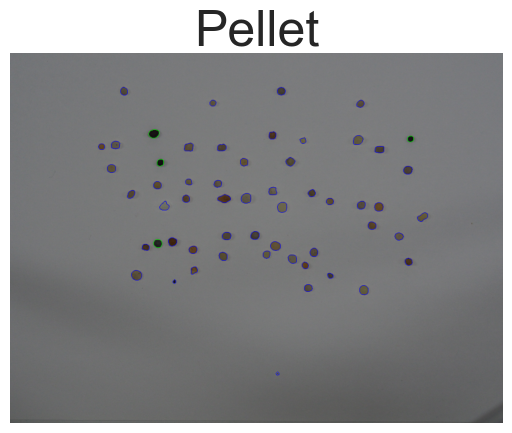

In [84]:
print('Azul: pellet, Rojo: fragmento, Verde: alquitrán')

imgFin,res = procesarPel(imgPog)

plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(imgFin,cv2.COLOR_BGR2RGB))
plt.title('Pellet')

Predicciones obtenidas= 56
Predicciones esperadas= 55
Diferencia obtenidas/esperadas= 1
Accuracy (TP/(n))= 0.9285714285714286
Precision (TP/(TP+FP)) = 1.0
Recall (TP/(TP+FN)) = 0.9285714285714286
F1 Score (2*(precision*recall)/(precision+recall)) = 0.9629629629629629


c:\Users\Usuario\anaconda3\envs\VC_P1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Text(0, 0.5, 'pel'), Text(0, 1.5, 'tar')]

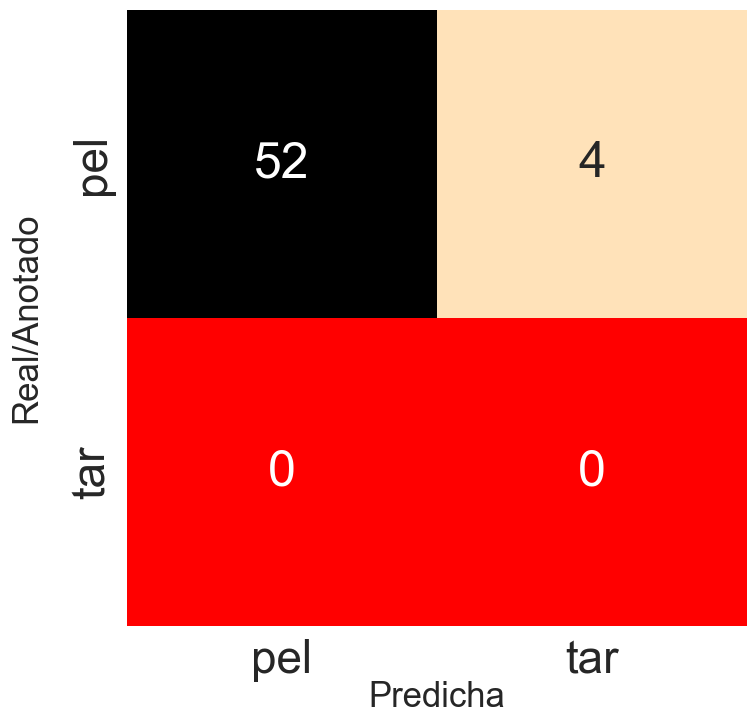

In [85]:
print(f"Predicciones obtenidas= {len(res)}")
print(f"Predicciones esperadas= 55")
print(f"Diferencia obtenidas/esperadas= {len(res)-55}")

predicciones = res
anotaciones = ['pel' for i in range(0,len(res))]
    
#Cálculo de métricas
accuracy = accuracy_score(anotaciones, predicciones)
#Para más de una clase se define la forma de promediar
precision = precision_score(anotaciones, predicciones,average='weighted')
recall = recall_score(anotaciones, predicciones,average='weighted')
f1score = f1_score(anotaciones, predicciones,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")

conf_matrix = confusion_matrix(anotaciones, predicciones)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)
labels = ['pel','tar']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


Azul: pellet, Rojo: fragmento, Verde: alquitrán


Text(0.5, 1.0, 'Alquitrán')

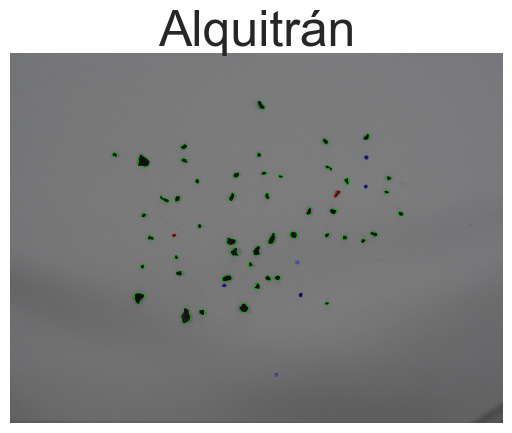

In [74]:
print('Azul: pellet, Rojo: fragmento, Verde: alquitrán')

imgFin,res = procesarPel(imgTog)

plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(imgFin,cv2.COLOR_BGR2RGB))
plt.title('Alquitrán')

Predicciones obtenidas= 56
Predicciones esperadas= 54
Diferencia obtenidas/esperadas= 2
Accuracy (TP/(n))= 0.8571428571428571
Precision (TP/(TP+FP)) = 1.0
Recall (TP/(TP+FN)) = 0.8571428571428571
F1 Score (2*(precision*recall)/(precision+recall)) = 0.9230769230769231


c:\Users\Usuario\anaconda3\envs\VC_P1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Text(0, 0.5, 'fra'), Text(0, 1.5, 'pel'), Text(0, 2.5, 'tar')]

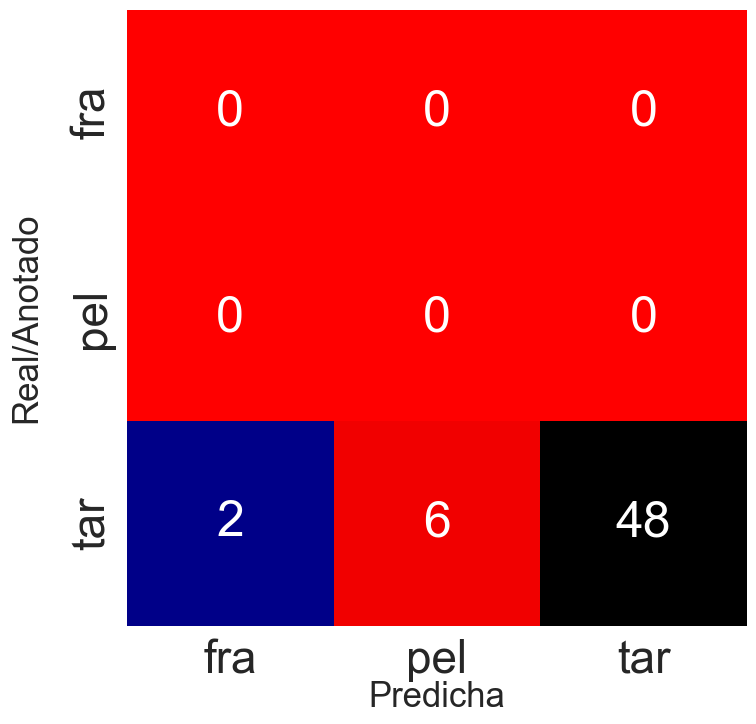

In [75]:
print(f"Predicciones obtenidas= {len(res)}")
print(f"Predicciones esperadas= 54")
print(f"Diferencia obtenidas/esperadas= {len(res)-54}")
predicciones = res
anotaciones = ['tar' for i in range(0,len(res))]
    
#Cálculo de métricas
accuracy = accuracy_score(anotaciones, predicciones)
#Para más de una clase se define la forma de promediar
precision = precision_score(anotaciones, predicciones,average='weighted')
recall = recall_score(anotaciones, predicciones,average='weighted')
f1score = f1_score(anotaciones, predicciones,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")

conf_matrix = confusion_matrix(anotaciones, predicciones)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)
labels = ['fra','pel','tar']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

Azul: pellet, Rojo: fragmento, Verde: alquitrán


Text(0.5, 1.0, 'Fragmento')

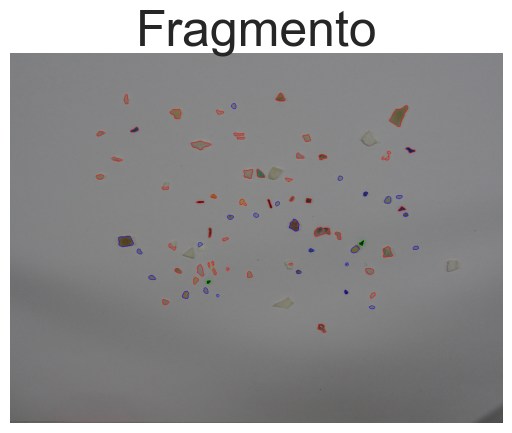

In [77]:
print('Azul: pellet, Rojo: fragmento, Verde: alquitrán')

imgFin,res = procesarPel(imgFog)

plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(imgFin,cv2.COLOR_BGR2RGB))
plt.title('Fragmento')

Predicciones obtenidas= 75
Predicciones esperadas= 80
Diferencia obtenidas/esperadas= -5
Accuracy (TP/(n))= 0.6533333333333333
Precision (TP/(TP+FP)) = 1.0
Recall (TP/(TP+FN)) = 0.6533333333333333
F1 Score (2*(precision*recall)/(precision+recall)) = 0.7903225806451613


c:\Users\Usuario\anaconda3\envs\VC_P1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Text(0, 0.5, 'fra'), Text(0, 1.5, 'pel'), Text(0, 2.5, 'tar')]

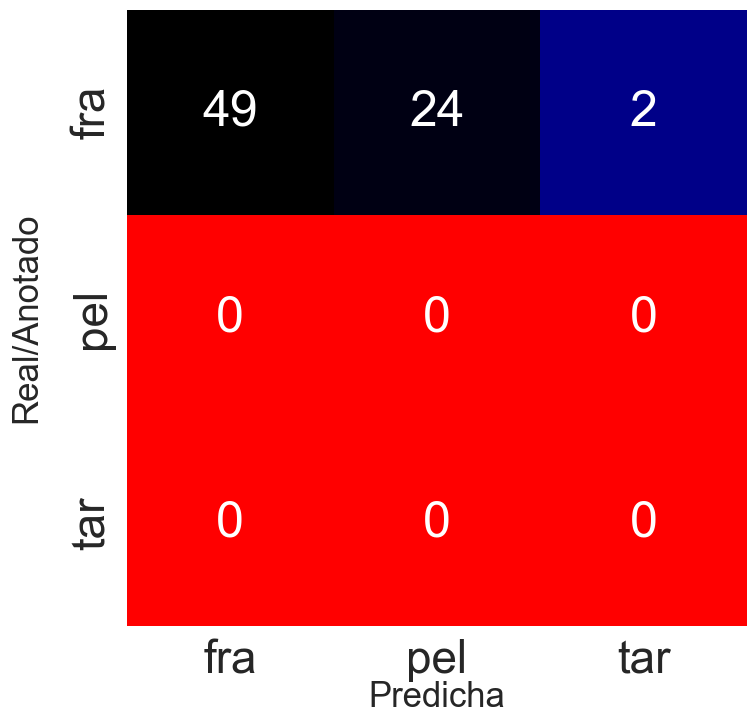

In [78]:
print(f"Predicciones obtenidas= {len(res)}")
print(f"Predicciones esperadas= 80")
print(f"Diferencia obtenidas/esperadas= {len(res)-80}")

predicciones = res
anotaciones = ['fra' for i in range(0,len(res))]
    
#Cálculo de métricas
accuracy = accuracy_score(anotaciones, predicciones)
#Para más de una clase se define la forma de promediar
precision = precision_score(anotaciones, predicciones,average='weighted')
recall = recall_score(anotaciones, predicciones,average='weighted')
f1score = f1_score(anotaciones, predicciones,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")

conf_matrix = confusion_matrix(anotaciones, predicciones)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)
labels = ['fra','pel','tar']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)